Зачада курсового проекта:
    Используя данные с платформы kaggle определить наличие или отсутствие зависимости расстояния между аэропортами вылета и прилёта и вероятнось задержки рейса.
    А конкретно: чем больше расстояния между аэропортами - тем выше вероятность задержки.
    данные: https://www.kaggle.com/datasets/jimschacko/airlines-dataset-to-predict-a-delay

In [1]:
from pandas import DataFrame, read_csv

In [2]:
dataset = read_csv('Airlines.csv')
dataset.head(10)

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,1,CO,269,SFO,IAH,3,15,205,1
1,2,US,1558,PHX,CLT,3,15,222,1
2,3,AA,2400,LAX,DFW,3,20,165,1
3,4,AA,2466,SFO,DFW,3,20,195,1
4,5,AS,108,ANC,SEA,3,30,202,0
5,6,CO,1094,LAX,IAH,3,30,181,1
6,7,DL,1768,LAX,MSP,3,30,220,0
7,8,DL,2722,PHX,DTW,3,30,228,0
8,9,DL,2606,SFO,MSP,3,35,216,1
9,10,AA,2538,LAS,ORD,3,40,200,1


Проверим распределение расстояния (Length) на нормальность распределения:

In [3]:
dataset.describe()

,id,Flight,DayOfWeek,Time,Length,Delay
count,539383.00000,539383.000000,539383.000000,539383.000000,539383.000000,539383.000000
mean,269692.00000,2427.928630,3.929668,802.728963,132.202007,0.445442
std,155706.60446,2067.429837,1.914664,278.045911,70.117016,0.497015
min,1.00000,1.000000,1.000000,10.000000,0.000000,0.000000
25%,134846.50000,712.000000,2.000000,565.000000,81.000000,0.000000
50%,269692.00000,1809.000000,4.000000,795.000000,115.000000,0.000000
75%,404537.50000,3745.000000,5.000000,1035.000000,162.000000,1.000000
max,539383.00000,7814.000000,7.000000,1439.000000,655.000000,1.000000


In [4]:
# Явные выбросы с нулевым расстоянием убираем из выборки
dataset[dataset['Length'] == 0]

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
179149,179150,F9,106,DEN,MSP,6,635,0,0
182840,182841,F9,107,MSP,DEN,6,851,0,0
188953,188954,F9,103,MSP,DEN,7,375,0,0
445578,445579,B6,493,BOS,SEA,7,1060,0,1


In [5]:
dataset = dataset[dataset['Length'] > 0]
dataset[dataset['Length'] == 0]

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay


(array([2.6360e+03, 1.1187e+04, 3.1355e+04, 4.8353e+04, 6.6029e+04,
        4.7481e+04, 4.9851e+04, 4.3950e+04, 4.0277e+04, 3.1010e+04,
        3.3456e+04, 2.4600e+04, 2.0781e+04, 1.2209e+04, 1.2336e+04,
        9.2500e+03, 6.5610e+03, 8.5800e+03, 5.6420e+03, 5.2340e+03,
        4.6860e+03, 3.3030e+03, 3.0610e+03, 3.9250e+03, 2.8900e+03,
        2.7940e+03, 1.9070e+03, 2.0080e+03, 1.4940e+03, 1.1610e+03,
        6.2400e+02, 1.1700e+02, 7.2000e+01, 1.8000e+01, 1.0500e+02,
        1.7000e+01, 4.1000e+01, 2.4000e+01, 1.0900e+02, 6.8000e+01,
        1.7000e+01, 3.7000e+01, 2.4000e+01, 3.1000e+01, 0.0000e+00,
        0.0000e+00, 6.0000e+00, 3.1000e+01, 0.0000e+00, 3.1000e+01]),
 array([ 23.  ,  35.64,  48.28,  60.92,  73.56,  86.2 ,  98.84, 111.48,
        124.12, 136.76, 149.4 , 162.04, 174.68, 187.32, 199.96, 212.6 ,
        225.24, 237.88, 250.52, 263.16, 275.8 , 288.44, 301.08, 313.72,
        326.36, 339.  , 351.64, 364.28, 376.92, 389.56, 402.2 , 414.84,
        427.48, 440.12, 452.76

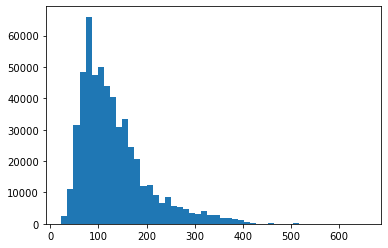

In [11]:
from matplotlib import pyplot as plt

plt.hist(dataset['Length'], bins=50)
# есть неравномерность колокола, однако, будем считать данное распределение относительно нормальным

In [12]:
# используя группировку по параметру Delay проверим среднее расстояние относительно задерживания рейса:
dataset[['Length','Delay']].groupby(by=['Delay']).mean()

,Length
Delay,
0,129.658895
1,135.370261


как видно, среднее расстояние отличается, переходим к проверке гипотезы:
    
    нулевая гипотеза: чем более параметр Length - тем выше вероятность Delay быть равным 1
    
    альтернативная гипотеза: вероятность Delay не зависит от Length

In [21]:
import numpy as np
from scipy import stats

In [60]:
# используя дисперсионный анализ для проверки 2 групп выборок, найдем зависимость 
# (дисперсия для задержанных рейсов и для незадержанных)

# отбираем группы задержанных и незадержанных рейсов
y1 = dataset[dataset['Delay'] == 1]['Length']
y2 = dataset[dataset['Delay'] == 0]['Length']

# считаем количество испытаний
n1 = y1.shape[0]
n2 = y2.shape[0]

In [61]:
# считаем средние значения по каждой выборке
y1_mean = y1.mean()
y2_mean = y2.mean()

y1_mean, y2_mean
# значения отличаются -> есть вероятность, что влияние фактора присутсвует

(135.37026092240586, 129.65889487690396)

In [75]:
# склеиваем факторы и считаем общую среднюю
y = np.concatenate([y1, y2])
y_mean = y.mean()
print(y_mean, y)

132.20298713891344 [205 222 165 ... 326 305 255]


In [65]:
# считаем сумму квадратов отклонений средних групповых значений от общего среднего значения
S2_F = n1 * (y1_mean - y_mean) ** 2 + n2 * (y2_mean - y_mean) ** 2 

# считаем остаточную сумму квадратов отклонений
S2_res = ((y1 - y1_mean) ** 2).sum() + ((y2 - y2_mean) ** 2).sum()

S2_F, S2_res

(4346227.914488476, 2647399302.632634)

In [69]:
# выполняем проверку на равенство с общей выборкой
round(S2_F + S2_res, 4) == round(((y - y_mean) ** 2).sum(), 4)
# разница после 4 знаков не играет большой роли, поскольку присутствует ошибка округления при рассчётах

True

In [71]:
# вычисляем несмещенные оценки дисперсий
k = 3
n = n1 + n2

k1 = k - 1
k2 = n - k

sigma2_F = S2_F / k1
sigma2_res = S2_res / k2

sigma2_F, sigma2_res

(2173113.957244238, 4908.263071832329)

In [72]:
# считаем статистику
T = sigma2_F / sigma2_res
T

442.74602347933677

In [77]:
# найдём Fcrit с уровнем значисмости a = 0.05
from scipy import stats

alpha = 0.05

F_crit = stats.f.ppf(1 - alpha, k1, k2)
F_crit

2.9957489121203706

Вывод: 
        влияение расстояние на вероятность задержки рейса подтверждается статистикой (442.75 > 3).